###by Alexander Guschin for MIPT Data mining in action course, 28.03.15

###you can download data from https://crowdanalytix.com/contests/modeling--predict-exacerbation-in-patients-with-respiratory-diseases

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import DataFrame as df
import numpy as np

from sklearn import *
from sklearn.ensemble import RandomForestClassifier
import sklearn

/usr/local/lib/python2.7/dist-packages/sklearn/pls.py:7: DeprecationWarning: This module has been moved to cross_decomposition and will be removed in 0.16
  "removed in 0.16", DeprecationWarning)


In [2]:
trainraw = read_csv('data/CAX_ExacerbationModeling_TRAIN_data.csv')
testraw = read_csv('data/CAX_ExacerbationModeling_Public_TEST_data.csv')

# Feature lists

In [5]:
cols = list(trainraw.columns)
cols.remove('Exacebator')

nvars = cols[1:331]
genes = cols[331:]

In [6]:
trainraw[nvars][:1]

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331
0,826,0,0,0,0,0,0,NaN,NaN,0,...,0.433839,0.411634,0,0.638849,0.648026,0.514303,0.179838,1,1,0.7


In [8]:
trainraw[genes][:1]

,V332,V333,V334,V335,V336,V337,V338,V339,V340,V341,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,0.5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,NaN,0,0.5


# Some plots

In [37]:
%matplotlib inline
from matplotlib.pyplot import *

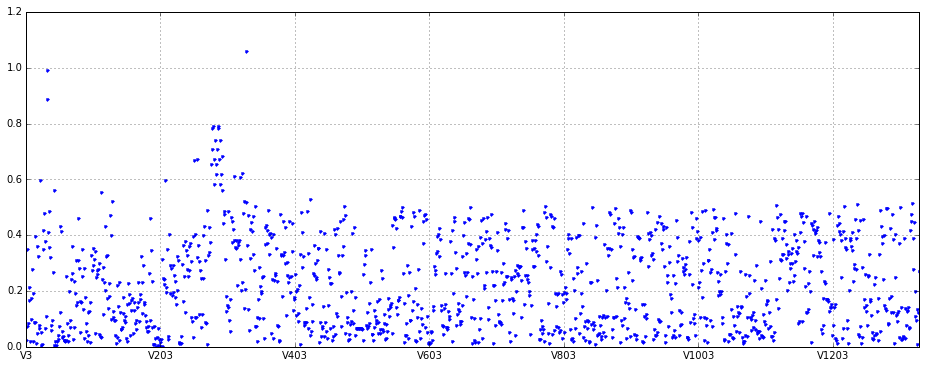

In [35]:
trainraw.mean(axis=0)[3:].plot(figsize=(16,6), marker='.', linestyle='')#, ylim=(0,.6))

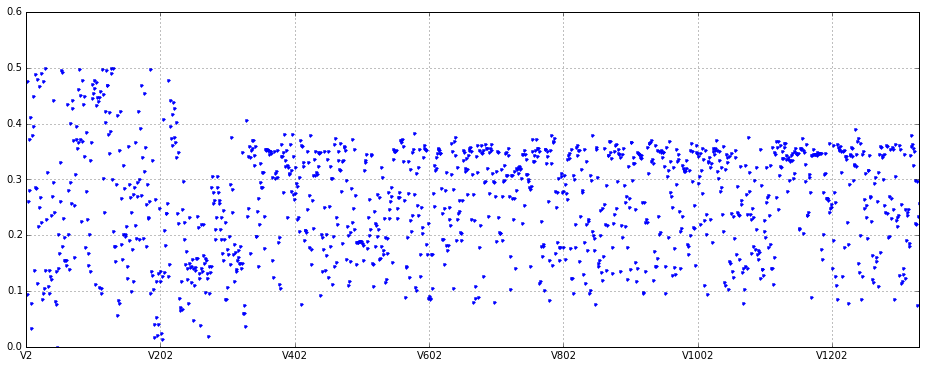

In [33]:
trainraw[nvars + genes].std(axis=0).plot(figsize=(16,6), marker='.', linestyle='', ylim=(0,.6))

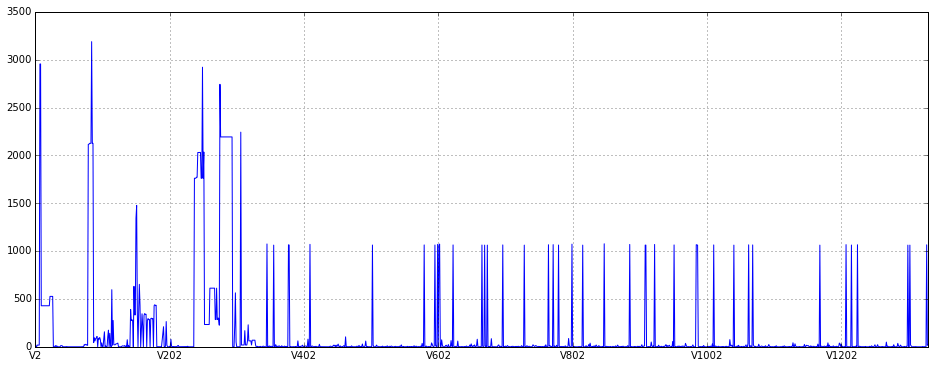

In [31]:
pd.isnull(trainraw[nvars + genes]).sum(axis=0).plot(figsize=(16,6))

# Scaling features

In [51]:
train, test = trainraw[:3000], trainraw[3000:]

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [61]:
scaler = StandardScaler()

xtrainN = scaler.fit_transform(train[nvars + genes].fillna(-1))
xtrainN = df(xtrainN, columns = [nvars + genes])

xtestN = scaler.transform(test[nvars + genes].fillna(-1))
xtestN = df(xtestN, columns = [nvars + genes])

#RandomForest

In [174]:
alg = RandomForestClassifier(n_estimators = 50, random_state = 0)
alg.fit(xtrainN, train.Exacebator)

prediction_rf = alg.predict_proba(xtestN)[:,1]

print '%.3f' % roc_auc_score(test.Exacebator, prediction_rf)

rf_imp = alg.feature_importances_

0.822


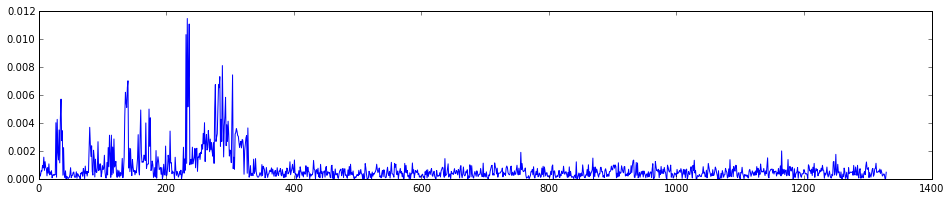

In [182]:
figure(figsize=(16,3))
plot(rf_imp)

#LinearSVC

In [173]:
alg = svm.LinearSVC(C=0.002)
alg.fit(xtrainN, train.Exacebator)

prediction_linearsvc = alg.decision_function(xtestN)

print '%.3f' % roc_auc_score(test.Exacebator, prediction_linearsvc)

weights_linearsvc = alg.coef_[0]
weights_linearsvc = abs(weights_linearsvc)/sum(abs(weights_linearsvc))

0.750


In [301]:
cols = np.array(nvars + genes) [rf_imp > 0.001]

alg = svm.LinearSVC(C=0.002)
alg.fit(xtrainN[cols], train.Exacebator)

prediction_linearsvc = alg.decision_function(xtestN[cols])

print '%.3f' % roc_auc_score(test.Exacebator, prediction_linearsvc)

0.835


#KNN

In [184]:
cols = np.array(nvars + genes) [rf_imp > 0.002]

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=100, p=1)
knn.fit(xtrainN[cols], train.Exacebator)

prediction_knn = knn.predict_proba(xtestN[cols])[:,1]

print '%.3f' % roc_auc_score(test.Exacebator, prediction_knn)

0.818


#Bagging for KNN

In [302]:
cols = np.array(nvars + genes) [rf_imp > 0.002]

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=100, p=1)

bagging = sklearn.ensemble.BaggingClassifier(
    knn, max_samples=1.0, max_features=0.5, bootstrap=True, bootstrap_features=False)

bagging.fit(xtrainN[cols], train.Exacebator)

prediction_bagging = bagging.predict_proba(xtestN[cols])[:,1]
print '%.3f' % roc_auc_score(test.Exacebator, prediction_bagging)

0.825


# Blending

In [312]:
import scipy
def plot_prediction(prediction, y_true = test.Exacebator.values, plotting = True):

    pred = prediction
    ans2x2 = df([y_true, pred]).T
    ans2x2 = ans2x2.sort(1)
    
    if plotting : 
        
        figure(figsize = (16,5))
        scatter(scipy.stats.rankdata(ans2x2[0], 'ordinal'), ans2x2[1], c=ans2x2[0], edgecolor='')
        grid()
        
    else :
        return scipy.stats.rankdata(ans2x2[0], 'ordinal'), ans2x2[1],  ans2x2[0]

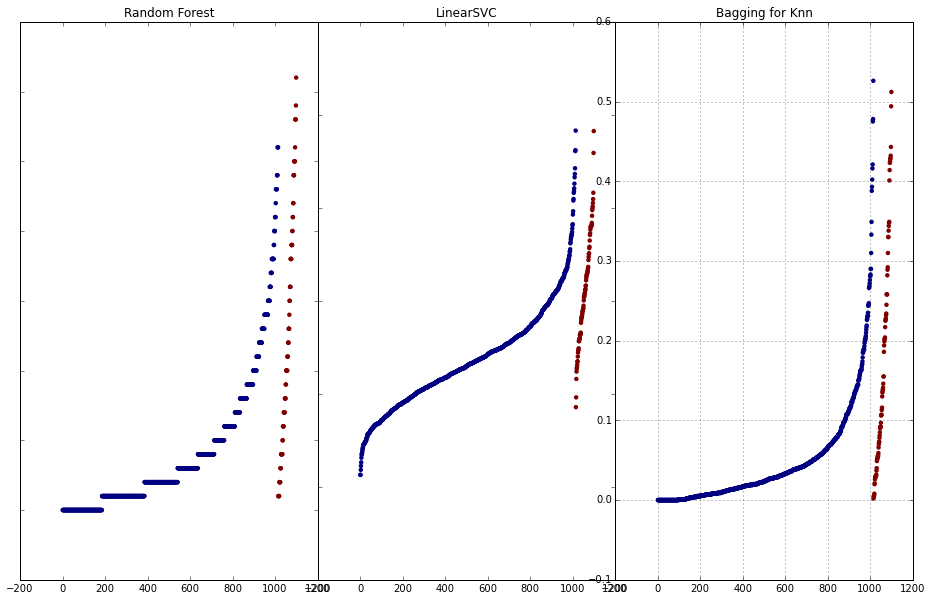

In [313]:
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16,10)) # sharey=True,

x1, y1, c1 = plot_prediction(prediction_rf, plotting = False)
x2, y2, c2 = plot_prediction(prediction_linearsvc, plotting = False)
x3, y3, c3 = plot_prediction(prediction_bagging, plotting = False)
ax1.scatter(x1, y1, c=c1, edgecolor='')
grid()
ax2.scatter(x2, y2, c=c2, edgecolor='')
grid()
ax3.scatter(x3, y3, c=c3, edgecolor='')
ax1.set_title('Random Forest')
ax2.set_title('LinearSVC')
ax3.set_title('Bagging for Knn')
grid()
f.subplots_adjust(wspace=0)
plt.setp([a.get_yticklabels() for a in f.axes[:-1]], visible=False);

0.844


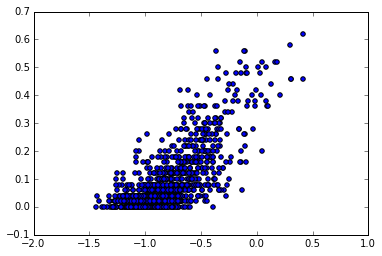

In [185]:
scatter(prediction_linearsvc, prediction_rf)
pred = prediction_linearsvc + prediction_rf
print '%.3f' % roc_auc_score(test.Exacebator, pred)

0.840


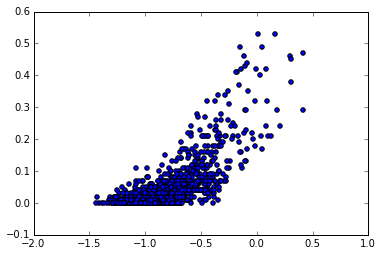

In [186]:
pred = prediction_knn + prediction_linearsvc
print '%.3f' % roc_auc_score(test.Exacebator, pred)
scatter(prediction_linearsvc, prediction_knn)

0.833


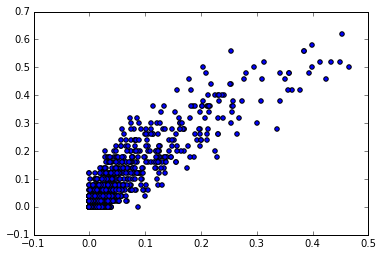

In [217]:
pred = prediction_bagging + prediction_rf
print '%.3f' % roc_auc_score(test.Exacebator, pred)
scatter(prediction_bagging, prediction_rf)

In [218]:
pred = (prediction_knn + prediction_linearsvc + prediction_rf) / 3
print '%.3f' % roc_auc_score(test.Exacebator, pred)

0.846


#Is our prediction stable?

In [237]:
cols = np.array(nvars + genes) [rf_imp > 0.002]

rf = RandomForestClassifier(n_estimators=50)

scores = cross_validation.cross_val_score(rf, xtrainN[cols], train.Exacebator, 'roc_auc', 3)
print '%.3f +- %.3f' % (np.mean(scores), np.std(scores)/2)

0.833 +- 0.005
